# Imports

In [1]:
import pandas as pd
import collections
import sys, os, importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import operator

from datetime import datetime
from pandas import DataFrame, concat

from sklearn.model_selection import train_test_split, learning_curve, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression



pd.set_option('display.max_rows', 100)

if os.path.join('..','0_funcoes_base') not in sys.path:
    sys.path.append(os.path.join('..','0_funcoes_base')) 

date_manipulator = importlib.import_module('date_manipulator')
df_manipulator = importlib.import_module('df_manipulator')
plot_manipulator = importlib.import_module('plot_manipulator')
file_manipulator = importlib.import_module('file_manipulator')

# Dados de configuração


In [2]:
input_config = {
    'file': {
        'ref_dir':'../1_pre_processamento/out/',
        'filename':'4_export_lunar_20200517_20200620.csv',
        'delimiter': ';'
    },
    'regions':[0,1]
}

output_config = {
    'file': {
        'ref_dir': './out',
        'prefix':'0_lr_'
    },
    'save_figures': False,
    'selected_columns':['z-norm','z-std_10', 'z-mean_50', 'z-corr-std_5', 'cp-norm', 'region_id','region_1_distance', 'region_1_counter'],
    'n_chunks': 6,
    'threshold_to_be_region_1': 0.1
}

# Funções

In [3]:
def undersample_majoritory_class(df, target_column, bounds, extra_values=None):
    region_1_initial_timestamps = df.loc[(df[target_column] == 0) & (df[target_column] != df[target_column].shift(-1))].index

    min_idx = df.index.min()
    max_idx = df.index.max()

    timestamps = []

    for ts in region_1_initial_timestamps:
        start_date = ts - pd.Timedelta(seconds=bounds[0])
        end_date = ts + pd.Timedelta(seconds=bounds[1])
        timestamps.extend(date_manipulator.get_date_window(start_date, end_date, bound=(min_idx, max_idx), to_pydatetime=False))

    if not extra_values:
        undersample_df = df[(df.index.isin(timestamps)) | df[target_column] == 1]
    else:
        undersample_df = df[(df.index.isin(extra_values)) | df[target_column] == 1] #list(map(lambda x: x[0].tolist(), extra_values)))

    return undersample_df


def undersample_majoritory_class_v2(df, target_column, start_events):
    min_idx = df.index.min()
    max_idx = df.index.max()

    timestamps = []

    for ts in region_1_initial_timestamps:
        start_date = ts - pd.Timedelta(seconds=bounds[0])
        end_date = ts + pd.Timedelta(seconds=bounds[1])
        timestamps.extend(date_manipulator.get_date_window(start_date, end_date, bound=(min_idx, max_idx), to_pydatetime=False))

    if not extra_values:
        undersample_df = df[(df.index.isin(timestamps)) | df[target_column] == 1]
    else:
        undersample_df = df[(df.index.isin(extra_values)) | df[target_column] == 1] #list(map(lambda x: x[0].tolist(), extra_values)))

    return undersample_df


def count_plot(df, column, title, palette=["#7159C1", "#DF0101"], figsize=(12,6), fontsize=18):
    fig, ax = plt.subplots(1, 1, figsize=figsize)   
    sns.countplot(column, data=df, palette=["#7159C1", "#DF0101"])
    plt.title(title, fontsize=fontsize)
    ax.set_ylabel('')

# Carrega o dataframe

In [4]:
df = df_manipulator.load_dataframes(input_config['file']['filename'], input_config['file']['ref_dir'], input_config['file']['delimiter'])
df.timestamp = pd.to_datetime(df.timestamp)
df_manipulator.set_index(df, 'timestamp', True)
df.sort_index(inplace=True)

# Seleciona colunas de interesse

In [5]:
df = df[output_config['selected_columns']]

df

,z-norm,z-std_10,z-mean_50,z-corr-std_5,cp-norm,region_id,region_1_distance,region_1_counter
timestamp,,,,,,,,
2020-05-17 20:14:37.800,0.556034,0.321725,0.050878,0.843891,-0.532930,0,50,0
2020-05-17 20:14:37.900,-0.039402,0.324012,0.048110,0.841856,-0.541349,0,51,0
2020-05-17 20:14:38.000,0.274901,0.326508,0.062383,0.602351,-0.541349,0,52,0
2020-05-17 20:14:38.100,0.274901,0.317193,0.073312,0.222601,-0.541349,0,53,0
2020-05-17 20:14:38.200,-0.039402,0.323049,0.077954,0.328441,-0.541349,0,54,0
...,...,...,...,...,...,...,...,...
2020-06-20 14:41:23.800,2.214042,0.637735,0.119045,-0.169956,0.730303,0,69,0
2020-06-20 14:41:23.900,2.214042,0.567993,0.174004,0.258179,0.859060,0,70,0
2020-06-20 14:41:24.000,1.669060,0.447913,0.222043,-0.059432,0.946878,0,71,0


# Substitui +inf, -inf values por valores com ffill

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.ffill(inplace=True)

df

,z-norm,z-std_10,z-mean_50,z-corr-std_5,cp-norm,region_id,region_1_distance,region_1_counter
timestamp,,,,,,,,
2020-05-17 20:14:37.800,0.556034,0.321725,0.050878,0.843891,-0.532930,0,50,0
2020-05-17 20:14:37.900,-0.039402,0.324012,0.048110,0.841856,-0.541349,0,51,0
2020-05-17 20:14:38.000,0.274901,0.326508,0.062383,0.602351,-0.541349,0,52,0
2020-05-17 20:14:38.100,0.274901,0.317193,0.073312,0.222601,-0.541349,0,53,0
2020-05-17 20:14:38.200,-0.039402,0.323049,0.077954,0.328441,-0.541349,0,54,0
...,...,...,...,...,...,...,...,...
2020-06-20 14:41:23.800,2.214042,0.637735,0.119045,-0.169956,0.730303,0,69,0
2020-06-20 14:41:23.900,2.214042,0.567993,0.174004,0.258179,0.859060,0,70,0
2020-06-20 14:41:24.000,1.669060,0.447913,0.222043,-0.059432,0.946878,0,71,0


# Transforma série temporal em dados supervisionados

In [7]:
ignored_columns = ['z-std_10', 'z-mean_50', 'z-corr-std_5', 'cp-norm', 'region_id', 'region_1_distance', 'region_1_counter']

df_supervised = df_manipulator.transform_to_supervised(df, previous_steps=5, forecast_steps=1)

ignored_columns_aux = []
for ic in ignored_columns:
    for col in df_supervised.columns.values:
        if ic in col and '(t)' not in col:
            ignored_columns_aux.append(col)

df_supervised.drop(list(set(ignored_columns_aux)), axis=1, inplace=True)

df_supervised

,z-norm(t-5),z-norm(t-4),z-norm(t-3),z-norm(t-2),z-norm(t-1),z-norm(t),z-std_10(t),z-mean_50(t),z-corr-std_5(t),cp-norm(t),region_id(t),region_1_distance(t),region_1_counter(t)
timestamp,,,,,,,,,,,,,
2020-05-17 20:14:38.300,0.556034,-0.039402,0.274901,0.274901,-0.039402,0.489720,0.313346,0.091882,-0.484383,-0.541349,0,55,0
2020-05-17 20:14:38.400,-0.039402,0.274901,0.274901,-0.039402,0.489720,0.489720,0.313673,0.098917,-0.289148,-0.541349,0,56,0
2020-05-17 20:14:38.500,0.274901,0.274901,-0.039402,0.489720,0.489720,0.339772,0.276741,0.102954,-0.776487,-0.541349,0,57,0
2020-05-17 20:14:38.600,0.274901,-0.039402,0.489720,0.489720,0.339772,0.783836,0.263174,0.112614,0.387222,-0.520027,0,58,0
2020-05-17 20:14:38.700,-0.039402,0.489720,0.489720,0.339772,0.783836,0.783836,0.289720,0.127810,0.387903,-0.498706,0,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-20 14:41:23.800,2.655212,2.301986,2.301986,2.603306,2.551409,2.214042,0.637735,0.119045,-0.169956,0.730303,0,69,0
2020-06-20 14:41:23.900,2.301986,2.301986,2.603306,2.551409,2.214042,2.214042,0.567993,0.174004,0.258179,0.859060,0,70,0
2020-06-20 14:41:24.000,2.301986,2.603306,2.551409,2.214042,2.214042,1.669060,0.447913,0.222043,-0.059432,0.946878,0,71,0


# Distribuição de Região no dataframe

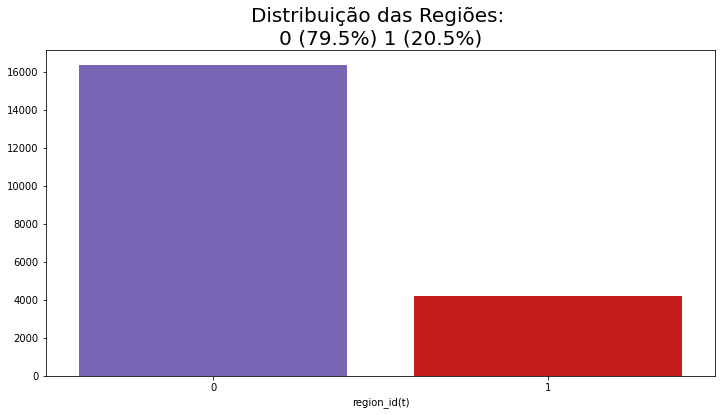

In [8]:
title = 'Distribuição das Regiões: \n' + str(0) + ' (' + str(round(df_supervised['region_id(t)'].value_counts()[0]/len(df_supervised) * 100,1)) + '%' + ') ' + str(1) + ' (' + str(round(df_supervised['region_id(t)'].value_counts()[1]/len(df_supervised) * 100,1)) + '%' + ')'
count_plot(df_supervised, 'region_id(t)', title=title, fontsize=20)

# Separação de dados para treino e teste respeitando a temporalidade e distribuição proporcional de eventos entre chunks

In [9]:
df_supervised, x_trains, x_tests, y_trains, y_tests = df_manipulator.custom_train_test_split(df_supervised, column_to_group_by='region_1_counter(t)', region_id_column='region_id(t)', chunks_size=output_config['n_chunks'], aux_split_column='region_1_split(t)', train_ignored_columns=['region_id(t)','region_1_distance(t)', 'region_1_counter(t)', 'region_1_split(t)'])

13 eventos por bloco no total de 82 eventos e 6 blocos 


Quebra-molas nº:
00 -> 13 : 0 (85.5%) 1 (14.5%)
13 -> 26 : 0 (76.6%) 1 (23.4%)
26 -> 39 : 0 (74.3%) 1 (25.7%)
39 -> 52 : 0 (76.2%) 1 (23.8%)
52 -> 65 : 0 (82.3%) 1 (17.7%)
65 -> 78 : 0 (79.3%) 1 (20.7%)
78 -> 82 : 0 (72.4%) 1 (27.6%)


In [10]:
x_validation_chunk = x_tests[-1]
y_validation_chunk = y_tests[-1]

x_tests = x_tests[:-1]
y_tests = y_tests[:-1]

# Classificadores para execução

In [11]:
classifiers = {
    "LogisiticRegression LL l1": LogisticRegression(solver='liblinear', penalty='l1'),
    "LogisiticRegression LL l2": LogisticRegression(solver='liblinear', penalty='l2'),
    "LogisiticRegression NG l2": LogisticRegression(solver='newton-cg', penalty='l2')
}

In [12]:
cms = {}
threshold = output_config['threshold_to_be_region_1']

for i in range (0, len(x_tests)):
    x_train, x_test = x_trains[i], x_tests[i]
    y_train, y_test = y_trains[i], y_tests[i]

    for key, classifier in classifiers.items():
        
        classifier.fit(x_train, y_train)

        y_pred = classifier.predict_proba(x_test)
        y_pred = (y_pred[:,1] >= threshold).astype('int')

        fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

        print(f'{key} - AUC: ', round(auc(fpr, tpr), 2) * 100, '%')

        if key not in cms:
            cms[key] = []

        cm = confusion_matrix(y_test, y_pred, labels=[0,1])
        cr = classification_report(y_test, y_pred, output_dict=True)

        cms[key].append({'classifier': classifier, 'cm': cm,  'precision': cr['1']['precision'], 'recall': cr['1']['recall'], 'report': cr})

LogisiticRegression LL l1 - AUC:  80.0 %
LogisiticRegression LL l2 - AUC:  81.0 %
LogisiticRegression NG l2 - AUC:  81.0 %
LogisiticRegression LL l1 - AUC:  80.0 %
LogisiticRegression LL l2 - AUC: 80.0 %
LogisiticRegression NG l2 - AUC:  80.0 %


>>> LogisiticRegression LL l1 : 83.7%



75.11%


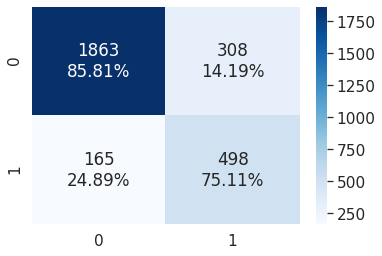

92.32%


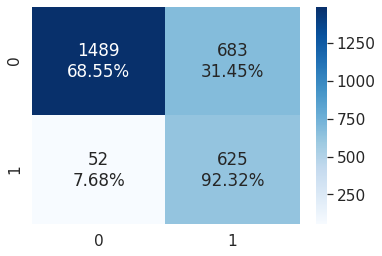

>>> LogisiticRegression LL l2 : 84.4%



76.17%


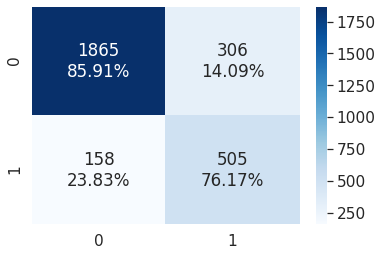

92.61%


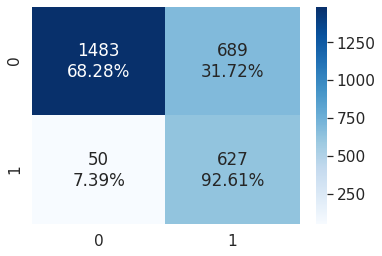

>>> LogisiticRegression NG l2 : 84.2%



76.02%


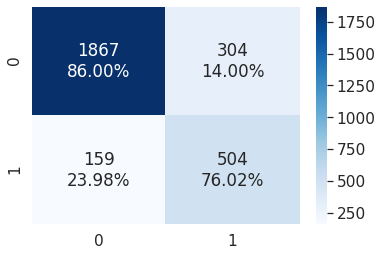

92.32%


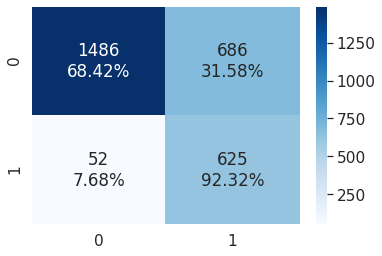

In [22]:
sns.set(font_scale=1.4)

recalls_by_classifiers = {}
statistics = []
for classifier in cms:
    statistic = {}

    mean_recall = np.mean([item['recall'] for item in cms[classifier]])
    recalls_by_classifiers[classifier] = mean_recall
    
    print(">>> {0} : {1:.1%}".format(classifier, mean_recall))
    print('\n\n')

    statistic['classifier'] = classifier
    statistic['recall'] = mean_recall*100

    for item in cms[classifier]:
        classifier_params = item['classifier'].get_params()

        print("{0:.2%}".format(item['recall']))

        statistic['solver'] = classifier_params['solver']
        statistic['penalty'] = classifier_params['penalty']

        group_counts = ["{0:0.0f}".format(value) for value in  item['cm'].flatten()]

        group_percentages = []
        f_item = item['cm'].flatten()
        for i in range(0, item['cm'].shape[0]):
            for y in range(0, item['cm'].shape[1]):
                group_percentages.append("{0:.2%}".format(item['cm'][i][y]/np.sum(item['cm'][i])))

        labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        statistics.append(statistic)

        sns.heatmap(item['cm'], annot=labels, fmt='', cmap='Blues')
        plt.show()


# Estatísticas das variações dos parâmetros dos classificadores

In [23]:
df_statistics = pd.DataFrame.from_records(data=statistics, exclude=['classifier'])
df_statistics.sort_values(by=['recall'], ascending=False)

,recall,solver,penalty
2,84.391702,liblinear,l2
3,84.391702,liblinear,l2
4,84.168577,newton-cg,l2
5,84.168577,newton-cg,l2
0,83.716088,liblinear,l1
1,83.716088,liblinear,l1


# Salva o modelo em disco

In [17]:
better_classifier_by_recall = max(recalls_by_classifiers.items(), key=operator.itemgetter(1))
chosen_classifier = better_classifier_by_recall[0]

print(f'Better classifer: {chosen_classifier}')

modelname = os.path.join(output_config['file']['ref_dir'], output_config['file']['prefix'] + 'model.sav')
joblib.dump(cms[chosen_classifier][0]['classifier'], open(modelname, 'wb'))
 

Better classifer: LogisiticRegression LL l2


# Carrega o modelo salvo

In [15]:
loaded_model = joblib.load(open(modelname, 'rb'))

# Testa com dados de validação

In [16]:
result = loaded_model.score(x_validation_chunk, y_validation_chunk)
print("{0:.2%}".format(result))

86.89%
